## Step 0:  Set up <a class="anchor" id="setup"></a>

In [41]:
# Import standard open libraries
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 

# AWS libraries and initialization
import boto3

# Load variables
%store -r df_raw
%store -r s3_bucket_name
%store -r s3_prefix
%store -r start_time
%store -r end_time
%store -r item_id
%store -r target_value
%store -r timestamp
%store -r forecast_dims
%store -r FORECAST_FREQ

## Step 1. Prepare Related Time Series <a class="anchor" id="RTS"></a>

Make sure RTS does not have any missing values, even if RTS extends into future. <br>
Trick:  create dataframe without any missing values using cross-join, faster than resample technique. <br>

In [7]:
# install dask for faster joins when df is large
!pip install "dask[dataframe]" 
import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
print('dask: {}'.format(dask.__version__))

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
dask: 2.11.0


In [8]:
# if you get memory allocation error in merges below, try overriding default value 0 to 1 for overcommit
# see https://www.kernel.org/doc/Documentation/vm/overcommit-accounting
# Next 2 commands - open new terminal and do these directly in terminal
# !sudo -i 
# !echo 1 > /proc/sys/vm/overcommit_memory
!cat /proc/sys/vm/overcommit_memory

1


In [9]:
idx = pd.date_range(start=start_time, end=end_time, freq=FORECAST_FREQ)
all_times = pd.DataFrame(index=idx)
print (f"Number of data points: {len(all_times.index)}")
print (f"Start date = {all_times.index.min()}")
print (f"End date = {all_times.index.max()}")

# Create timestamp column
all_times.reset_index(inplace=True)
all_times.columns = [timestamp]

print(all_times.dtypes)
print(all_times.isna().sum())
print(all_times.shape)
all_times.sample(5)

Number of data points: 5856
Start date = 2019-07-01 00:00:00
End date = 2020-02-29 23:00:00
pickup_hourly    datetime64[ns]
dtype: object
pickup_hourly    0
dtype: int64
(5856, 1)


,pickup_hourly
2751,2019-10-23 15:00:00
1162,2019-08-18 10:00:00
3219,2019-11-12 03:00:00
2229,2019-10-01 21:00:00
3123,2019-11-08 03:00:00


In [11]:
%%time
# create master template of all possible locations and items

items = pd.DataFrame(list(df_raw[item_id].unique()))
items.columns = [item_id]
# print(items.head(2))
master_records = items.copy()
print(master_records.shape, items.shape)

# check you did the right thing
num_items = len(master_records[item_id].value_counts())
print(f"num items = {num_items}")
master_records.tail()

(260, 1) (260, 1)
num items = 260
CPU times: user 54 ms, sys: 0 ns, total: 54 ms
Wall time: 55.1 ms


,pulocationid
255,83
256,84
257,85
258,86
259,87


In [12]:
%%time
# cross-join to create master template of all possible locations and items and times
all_times['key'] = "1"
master_records['key'] = "1"
all_times.set_index('key', inplace=True)
master_records.set_index('key', inplace=True)

# Do the cross-join
print("doing the merge...")
full_history = master_records.merge(all_times, how="outer", left_index=True, right_index=True)
print("done w/ merge...")
full_history.reset_index(inplace=True, drop=True)

# make sure you don't have any nulls
print(full_history.shape)
print("checking nulls...")
print(full_history.isna().sum())
full_history.tail()

doing the merge...
done w/ merge...
(1522560, 2)
checking nulls...
pulocationid     0
pickup_hourly    0
dtype: int64
CPU times: user 159 ms, sys: 22 ms, total: 181 ms
Wall time: 190 ms


,pulocationid,pickup_hourly
1522555,87,2020-02-29 19:00:00
1522556,87,2020-02-29 20:00:00
1522557,87,2020-02-29 21:00:00
1522558,87,2020-02-29 22:00:00
1522559,87,2020-02-29 23:00:00


In [15]:
# create small df of target_values - to merge later using dask
temp_target = df_raw[forecast_dims + [target_value]].copy()
# add key for faster join
temp_target['ts_key'] = temp_target[timestamp].astype(str) + "-" + temp_target[item_id]
temp_target = temp_target.groupby('ts_key').sum()
# temp_target.drop(forecast_dims, inplace=True, axis=1)
# temp_target.set_index('ts_key', inplace=True)
print(temp_target.shape, df_raw.shape)
display(temp_target.head(2))

(1507488, 1) (1507488, 9)


,trip_quantity
ts_key,
2019-07-01 00:00:00-1,0
2019-07-01 00:00:00-10,1


<b> Parallelization for faster merge </b><br>
Below, I used dask.  I also tried ray through modin library.  I found error when adding a new column to modin dataframe.  Maybe by the time you use this notebook the modin/ray problem will be solved.
https://github.com/modin-project/modin/issues/2442

For reference, here are dask best practices:
<ul>
    <li>Choose partitions to be #items if your time series have more dimensions than just item_id, see <a href="https://docs.dask.org/en/latest/best-practices.html" target="_blank">https://docs.dask.org/en/latest/best-practices.html</a></li>
    <li>Make sure reset_index is only done in pandas and not dask, see <a href="https://docs.dask.org/en/latest/dataframe-best-practices.html" target="_blank">https://docs.dask.org/en/latest/dataframe-best-practices.html</a></li>
    </ul>

In [18]:
%%time

# USING dask

# convert pandas to dask df
print(type(full_history))
num_partitions = 1
print(f"using num_partitions = {num_partitions}")
large_df = dd.from_pandas(full_history, npartitions=num_partitions)
print(type(large_df))

# add key for faster join with target_value
large_df['ts_key'] = large_df[timestamp].astype(str) + "-" + large_df[item_id]   
print(large_df.shape, full_history.shape)
display(large_df.head(2))

# CPU times: user 2.94 s, sys: 178 ms, total: 3.12 s
# Wall time: 3.11 s

<class 'pandas.core.frame.DataFrame'>
using num_partitions = 1
<class 'dask.dataframe.core.DataFrame'>
(Delayed('int-b1c4e037-1129-4c1b-8e0d-2b5ad8c8868b'), 3) (1522560, 2)


,pulocationid,pickup_hourly,ts_key
0,1,2019-07-01 00:00:00,2019-07-01 00:00:00-1
1,1,2019-07-01 01:00:00,2019-07-01 01:00:00-1


CPU times: user 2.11 s, sys: 209 ms, total: 2.32 s
Wall time: 2.64 s


In [19]:
%%time 

# merge in original target_value
temp = large_df.merge(temp_target, how="left", right_index=True, left_on="ts_key")
print(temp.shape, full_history.shape)
display(temp.head(3))

# CPU times: user 637 ms, sys: 8.18 ms, total: 645 ms
# Wall time: 640 ms

(Delayed('int-c558edae-e637-4378-9ad4-b587af13cdff'), 4) (1522560, 2)


,pulocationid,pickup_hourly,ts_key,trip_quantity
0,1,2019-07-01 00:00:00,2019-07-01 00:00:00-1,0.0
1,1,2019-07-01 01:00:00,2019-07-01 01:00:00-1,0.0
2,1,2019-07-01 02:00:00,2019-07-01 02:00:00-1,0.0


CPU times: user 4.45 s, sys: 265 ms, total: 4.72 s
Wall time: 4.7 s


In [20]:
%%time 

# convert dask df back to pandas df
# # Below is too small !?  rows got dropped, why?
print(type(temp))
temp3 = temp.compute()
print(type(temp3))
temp3.drop('ts_key', axis=1, inplace=True)
print(temp3.shape, full_history.shape)

# check nulls
print(temp3.isna().sum())
display(temp3.sample(3))
temp3[target_value].describe()

# CPU times: user 4.48 s, sys: 238 ms, total: 4.72 s
# Wall time: 4.7 s

<class 'dask.dataframe.core.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
(1522560, 3) (1522560, 2)
pulocationid         0
pickup_hourly        0
trip_quantity    15072
dtype: int64


,pulocationid,pickup_hourly,trip_quantity
1414910,70,2019-11-28 14:00:00,0.0
1153168,41,2020-02-10 16:00:00,33.0
1261205,89,2019-09-29 05:00:00,0.0


CPU times: user 4.01 s, sys: 201 ms, total: 4.21 s
Wall time: 4.2 s


count    1.507488e+06
mean     3.316301e+01
std      9.459279e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      6.000000e+00
max      2.085000e+03
Name: trip_quantity, dtype: float64

In [23]:
# Check you did the right thing
# Check original target_values
df_raw[target_value].describe()

count    1.507488e+06
mean     3.316301e+01
std      9.459279e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      6.000000e+00
max      2.085000e+03
Name: trip_quantity, dtype: float64

In [24]:
# Careful!!
# Really replace full_history with merged values
print(full_history.shape)
full_history = temp3.copy()
print(full_history.shape)
print(type(full_history))
del temp, temp_target, temp3
full_history.head(2)

(1522560, 2)
(1522560, 3)
<class 'pandas.core.frame.DataFrame'>


,pulocationid,pickup_hourly,trip_quantity
0,1,2019-07-01 00:00:00,0.0
1,1,2019-07-01 01:00:00,0.0


In [25]:
# Candidate variables for hourly data
full_history['day_of_week'] = full_history[timestamp].dt.day_name().astype(str)
full_history['hour_of_day'] = full_history[timestamp].dt.hour.astype(str)
full_history['day_hour_name'] = full_history['day_of_week'] + "_" + full_history['hour_of_day']
full_history['weekend_flag'] = full_history[timestamp].dt.dayofweek
full_history['weekend_flag'] = (full_history['weekend_flag'] >= 5).astype(int)
full_history['is_sun_mon'] = 0
full_history.loc[((full_history.day_of_week=="Sunday") | (full_history.day_of_week=="Monday")), 'is_sun_mon'] = 1

print(full_history.sample(5))

        pulocationid       pickup_hourly  trip_quantity day_of_week  \
1194843           49 2019-07-10 03:00:00            0.0   Wednesday   
1475406            8 2020-02-17 06:00:00            0.0      Monday   
782300           221 2019-11-21 20:00:00            0.0    Thursday   
471421           174 2019-10-31 13:00:00            0.0    Thursday   
1091677           32 2019-10-11 13:00:00            0.0      Friday   

        hour_of_day day_hour_name  weekend_flag  is_sun_mon  
1194843           3   Wednesday_3             0           0  
1475406           6      Monday_6             0           1  
782300           20   Thursday_20             0           0  
471421           13   Thursday_13             0           0  
1091677          13     Friday_13             0           0  


In [29]:
# zoom-in time slice so you can see patterns
location_picked = "231"
df_plot = full_history.loc[(full_history[item_id] == location_picked), :].copy()
df_plot = full_history.loc[((full_history[timestamp]>"2020-01-10")
                           & (full_history[timestamp]<end_time)
                           & (full_history[item_id] == location_picked)), :].copy()
print(df_plot.shape, full_history.shape)
df_plot = df_plot.groupby([timestamp]).sum()
df_plot.reset_index(inplace=True)
df_plot.sample(3)

(1222, 8) (1522560, 8)


,pickup_hourly,trip_quantity,weekend_flag,is_sun_mon
194,2020-01-18 03:00:00,65.0,1,0
1174,2020-02-27 23:00:00,164.0,0,0
169,2020-01-17 02:00:00,42.0,0,0


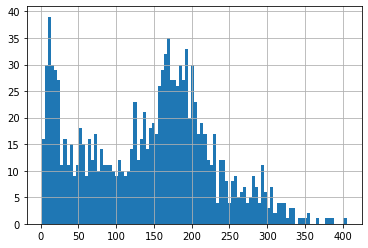

In [30]:
#check: target_value distribution in full dataframe looks same as original
df_plot[target_value].hist(bins=100)

## Step 2. Visualize Related Time Series <a class="anchor" id="visualize_rts"></a>

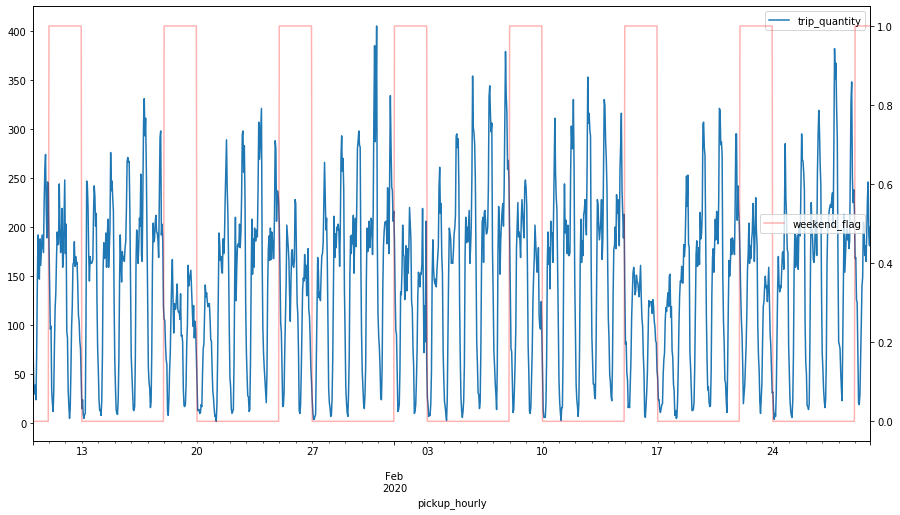

In [31]:
# Visualize candidate RTS variables
plt.figure(figsize=(15, 8))
ax = plt.gca()
df_plot.plot(x=timestamp, y=target_value, ax=ax);
ax2 = ax.twinx()
df_plot.plot(x=timestamp, y='weekend_flag', color='red', alpha=0.3, ax=ax2);

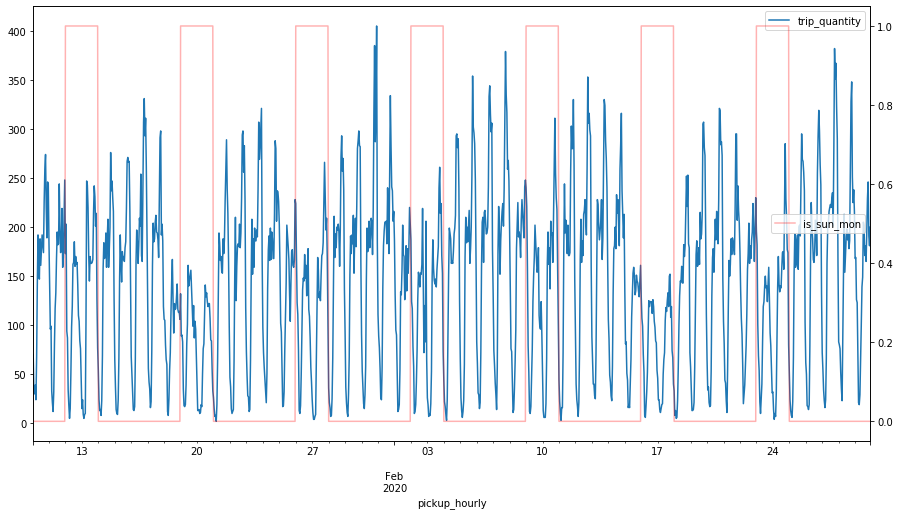

In [32]:
# EXAMPLE HOURLY RTS

# Visualize candidate RTS variables is_sun_mon
plt.figure(figsize=(15, 8))
ax = plt.gca()
df_plot.plot(x=timestamp, y=target_value, ax=ax);
ax2 = ax.twinx()
df_plot.plot(x=timestamp, y='is_sun_mon', color='red', alpha=0.3, ax=ax2);

It looks like lowest taxis rides are a combination of day and hour that seems to matter, not just day of week.

In [34]:
# EXAMPLE HOURLY RTS

# Assemble RTS - include whatever columns you finally decide
rts = full_history[forecast_dims + ['day_hour_name']].copy()

print(rts.shape)
print(rts.isnull().sum())
print(f"rts start: {rts[timestamp].min()}")
print(f"rts end: {rts[timestamp].max()}")
rts.sample(5)

(1522560, 3)
pickup_hourly    0
pulocationid     0
day_hour_name    0
dtype: int64
rts start: 2019-07-01 00:00:00
rts end: 2020-02-29 23:00:00


,pickup_hourly,pulocationid,day_hour_name
1383993,2019-09-21 09:00:00,66,Saturday_9
1232078,2019-10-05 14:00:00,54,Saturday_14
1287031,2020-01-07 07:00:00,92,Tuesday_7
304661,2019-07-07 05:00:00,149,Sunday_5
1221498,2019-11-21 18:00:00,52,Thursday_18


## Step 3. Save Related Time Series <a class="anchor" id="save_rts"></a>

In [37]:
# Save rts to S3
local_file = "rts.csv"
# Save merged file locally
rts.to_csv(local_file, header=False, index=False)

key = f"{s3_prefix}/{local_file}"
boto3.Session().resource('s3').Bucket(s3_bucket_name).Object(key).upload_file(local_file)

In [38]:
%store df_raw
%store s3_bucket_name
%store s3_prefix
%store start_time
%store end_time
%store item_id
%store target_value
%store timestamp
%store FORECAST_FREQ
%store forecast_dims

Stored 'df_raw' (DataFrame)
Stored 's3_bucket_name' (str)
Stored 's3_prefix' (str)
Stored 'start_time' (Timestamp)
Stored 'end_time' (Timestamp)
Stored 'item_id' (str)
Stored 'target_value' (str)
Stored 'timestamp' (str)
Stored 'FORECAST_FREQ' (str)
Stored 'forecast_dims' (list)
